# Test Projection of Ellipsoid

This notebook tests the procedure for projecting the (x, y) pixel coordinate of an image of an ellipsoid to the (longitude, latitude) coordinate on the surface of ellipsoid.  The purpose is to debug the algorithm of `EllipsoidProjection.xy2lonlat`.

The problem here is that after projection-deprojection cycle, some (longitude, latitude) pairs can't return to the original values, although most of them do.  Below is the test to show the problem.

In [203]:
import jylipy
ipl.reload(jylipy.vector)

<module 'jylipy.vector' from '/Users/jyli/Work/Git/jylipy/jylipy/vector.py'>

In [156]:
from jylipy.vector import EllipsoidProjection, Vector

a, b, c = 500, 480, 400
los = 0, 1, 1

v = EllipsoidProjection([a, b, c], Vector(*los), 2)

lat, lon = np.mgrid[0:181, 0:360]
lat -= 90
lat = lat.astype(float)
lon = lon.astype(float)
x, y = v.lonlat2xy(lon, lat)
lon1, lat1 = v.xy2lonlat(x, y)

ww = np.isfinite(lon) & np.isfinite(lon1) & (abs(lat) != 90)
diff_lon = np.zeros_like(lon)
diff_lon[ww] = (lon[ww] - lon1[ww]) % 360
diff_lon[diff_lon > 180] -= 360
diff_lat = np.zeros_like(lon)
diff_lat[ww] = (lat[ww] - lat1[ww]) % 360
diff_lat[diff_lat > 180] -= 360

print('Ellipsoid with axes: {}, {}, {}'.format(a, b, c))
print('Viewed from line-of-sight: {}, {}, {}'.format(*los))

Ellipsoid with axes: 500, 480, 400
Viewed from line-of-sight: 0, 1, 1


The difference map between recovered longitude/latitude and the original ones are shown below.  It appears that the difference is along the southern limb.  It's likely that this is caused by the wrong choice of the two roots of `t`.  Right now the `t` is taken as the larger solution of the quadratic equation, which should corresond to the side of ellipsoid towards the viewer.  Test shows that, if the other solution is taken, then those problematic area is good.  This doesn't make sense.

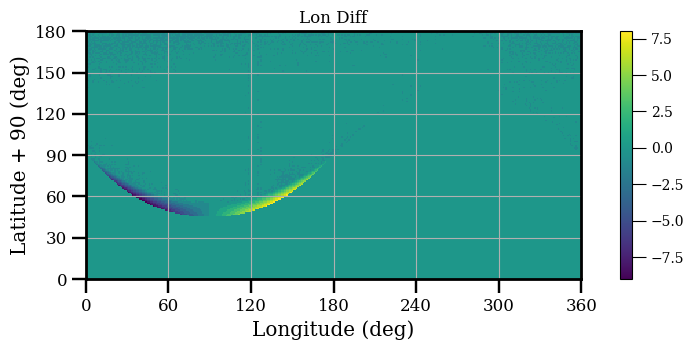

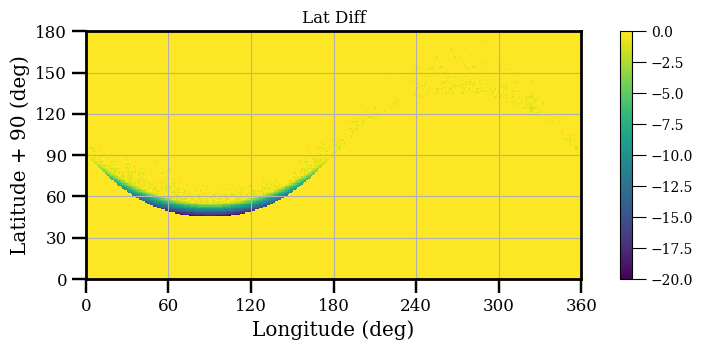

In [157]:
%matplotlib inline
plt.figure(figsize=(8, 3.6))
plt.imshow(diff_lon)
plt.grid()
jp.pplot(xlabel='Longitude (deg)', ylabel='Latitude + 90 (deg)', xticks=np.linspace(0, 360, 7), yticks=np.linspace(0, 180, 7), xlim=[0, 360], ylim=[0, 180], title='Lon Diff')
plt.colorbar()

plt.figure(figsize=(8, 3.6))
plt.imshow(diff_lat)
plt.grid()
jp.pplot(xlabel='Longitude (deg)', ylabel='Latitude + 90 (deg)', xticks=np.linspace(0, 360, 7), yticks=np.linspace(0, 180, 7), xlim=[0, 360], ylim=[0, 180], title='Lat Diff')
plt.colorbar()


Below figure shows the `t` values along longitudes.  It is strange to see that the two branches of `t` cross each other at latitudes between -40 and -45 deg.  Apparently, the problematic area corresponds to the latitudes where the cross-over happens.

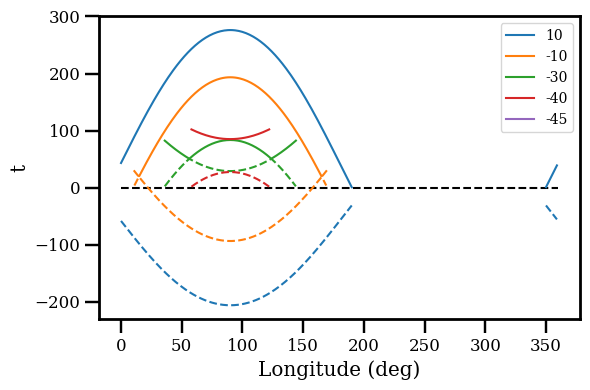

In [160]:

plot_lat = [10, -10, -30, -40, -45]
plt.figure(figsize=(6,4))
for ll in plot_lat:
    p = plt.plot(info['t'][ll+90, :, 1])
    plt.plot(info['t'][ll+90, :, 0], '--', color=p[0].get_color(), label='_nolegend_')
jp.pplot(xlabel='Longitude (deg)', ylabel='t')
plt.hlines(0, 0, 360, color='k', ls='--')
plt.legend(plot_lat)

The problem needs to be understood with visuals.  Below are the visual tests for 2D and 3D cases.

## 2D Case

Look at the 2D case with an ellipse.  A line passing the center is assumed to be the projection plan.  The cross points of lines parallel to the normal direction of the projection line with the ellipses are calculated following the same algorithm for the 3D case.  The parameter `t` is plotted.  The whole process is visualized.

t =  [-1.14065527 -0.24941626]
t =  [-2.1976439   1.51972724]
t =  [0.15682774 1.2195485 ]


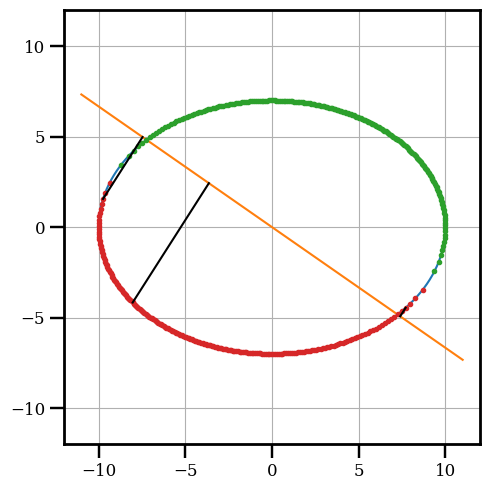

In [73]:
# for 2D case

plt.figure(figsize=(5, 5))

# generate an ellips with axes 10 and 6
a = 10
b = 7
theta = np.linspace(0, np.pi*2, 500)
x_ell = a * np.cos(theta)
y_ell = b * np.sin(theta)

# plot ellipse
plt.plot(x_ell, y_ell)
jp.pplot(xlim=[-12, 12], ylim=[-12, 12])
plt.grid()


# a line of projection along normal (alpha, beta)
alpha = 2
beta = 3
normal = np.array([alpha, beta])
x_lin = np.linspace(-11, 11, 300)
y_lin = -alpha * x_lin / beta
# plot projection line
plt.plot(x_lin, y_lin)


# calculate cross of normals along the line and the ellips
p1 = np.full_like(x_lin, ((normal / [a, b])**2).sum())
p2 = 2 * (normal * np.moveaxis(np.stack([x_lin, y_lin]), 0, -1) / np.array([10, 7])**2).sum(axis=-1)
p3 = ((np.moveaxis(np.stack([x_lin, y_lin]), 0, -1) / [10, 7])**2).sum(axis=-1) - 1
t = jp.quadeq(p1, p2, p3)
# plot the crossing points on the positive t side
xx = alpha * t[:,1] + x_lin
yy = beta * t[:,1] + y_lin
plt.plot(xx, yy, '.')
# plot the crossing points on the negative t side
xx = alpha * t[:,0] + x_lin
yy = beta * t[:,0] + y_lin
plt.plot(xx, yy, '.')


# check the projection with t
index = 48
print('t = ', t[index])
plt.plot([x_lin[index], xx[index]], [y_lin[index], yy[index]], '-', color='k')

index = 100
print('t = ', t[index])
plt.plot([x_lin[index], xx[index]], [y_lin[index], yy[index]], '-', color='k')

index = 250
print('t = ', t[index])
plt.plot([x_lin[index], xx[index]], [y_lin[index], yy[index]], '-', color='k')

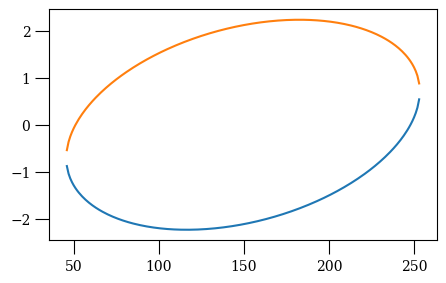

In [74]:
plt.figure(figsize=(5,3))
plt.plot(t[:,0])
plt.plot(t[:,1])

From this visualization, my original understanding appears to be correct.  For the two solutions of the quadratic equation that calculates the two cross points, the two solutions correspond to the two `t` parameter values that represent the two cross points.  When the two points are on the opposite sides of the projection plane, two solutions have different signs (one positive and one negative), and when they are on the same side, the two solutions have the same sign.  But for the front side of the ellipse, `t` always takes the larger of the two roots.

Need to look at 3D case to find out the problem.

## 3D Case

In [209]:
import jylipy
ipl.reload(jylipy.vector)

<module 'jylipy.vector' from '/Users/jyli/Work/Git/jylipy/jylipy/vector.py'>

In [509]:
# calculate xy2lonlat using the problematic procedure
#
# the quadratic equation solutions are saved in parameter `t`
# the surface points are saved in `(x1, y1, z1)` and `(x2, y2, z2)`, corresponding to
#   the larger and smaller `t` solution, respectively.
# the original (longitude, latitutde) are in `(lon, lat)`
# the recovered (longitude, latitude) are in `(lon1, lat1)`

from jylipy import quadeq
from jylipy.vector import EllipsoidProjection, Vector
import astropy.units as u

a, b, c = 500, 480, 400
los = 0, 1, 1

v = EllipsoidProjection([a, b, c], Vector(*los), 2)

lat, lon = np.mgrid[0:181, 0:360]
lat -= 90
x, y = v.lonlat2xy(lon, lat)

yarr = (np.asanyarray(y) - v.body_center[0]) * v.pixel_scale
xarr = (np.asanyarray(x) - v.body_center[1]) * v.pixel_scale

# calculate lon/lat
vb = Vector(xarr, yarr, 0).paraproj(
        v.view_point, pa=v.position_angle, invert=True)
n = v.view_point
p1 = np.full_like(vb.x, ((n.xyz / v.r)**2).sum())
p2 = 2 * (n.xyz * np.moveaxis(vb.xyz, 0, -1) / v.r**2).sum(
        axis=-1)
p3 = ((np.moveaxis(vb.xyz, 0, -1) / v.r)**2).sum(axis=-1) - 1
t = quadeq(p1, p2, p3)
# output arrays
lon1 = np.full_like(xarr, np.nan)
lat1 = np.full_like(xarr, np.nan)
# take the larger of the two roots
w = np.isfinite(t[..., 1])
x1 = n.x * t[..., 1][w] + vb.x[w]
y1 = n.y * t[..., 1][w] + vb.y[w]
z1 = n.z * t[..., 1][w] + vb.z[w]
vect = Vector(x1, y1, z1)
lon1[w] = vect.lon
lat1[w] = vect.lat

# the smaller of the two roots
w = np.isfinite(t[..., 0])
x2 = n.x * t[..., 0][w] + vb.x[w]
y2 = n.y * t[..., 0][w] + vb.y[w]
z2 = n.z * t[..., 0][w] + vb.z[w]

lat1 = u.Quantity(lat, u.rad).to(v.unit, v.equivalencies).value
lon1 = u.Quantity(lon % (2 * np.pi), u.rad).to(v.unit,
        v.equivalencies).value

print('Ellipsoid with axes: {}, {}, {}'.format(a, b, c))
print('Viewed from line-of-sight: {}, {}, {}'.format(*los))

Ellipsoid with axes: 500, 480, 400
Viewed from line-of-sight: 0, 1, 1


In [521]:
# 3d visualization

%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

# plot surface
lon, lat = np.mgrid[0:361, -90:91]
lat = np.deg2rad(lat)
lon = np.deg2rad(lon)
coslon = np.cos(lon)
sinlon = np.sin(lon)
coslat = np.cos(lat)
xcomp = coslon * coslat
ycomp = sinlon * coslat
zcomp = np.sin(lat)
r_recip = np.sqrt((xcomp / a)**2 + (ycomp / b)**2 + (zcomp / c)**2)
x = xcomp / r_recip
y = ycomp / r_recip
z = zcomp / r_recip
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.25)

# plot wireframe
lon, lat = np.mgrid[0:13, -3:4]
lat = np.deg2rad(lat*30)
lon = np.deg2rad(lon*30)
coslon = np.cos(lon)
sinlon = np.sin(lon)
coslat = np.cos(lat)
xcomp = coslon * coslat
ycomp = sinlon * coslat
zcomp = np.sin(lat)
r_recip = np.sqrt((xcomp / a)**2 + (ycomp / b)**2 + (zcomp / c)**2)
x = xcomp / r_recip
y = ycomp / r_recip
z = zcomp / r_recip
#ax.plot_wireframe(x, y, z, color='g', lw=1)

# Adjustment of the axes, so that they all have the same span:
max_radius = max(a, b, c)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

# axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#plt.show()

# plot projection plane
ax.plot_wireframe(vb.x, vb.y, vb.z, alpha=0.3, color='g')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [523]:
# adjust view angle
ax.view_init(elev=-9, azim=142)
plt.show()


In [524]:
# plot vertical lines
vbw = vb[w]
ww = 8600

ax.plot([vbw.x[ww], x1[ww]], [vbw.y[ww], y1[ww]], [vbw.z[ww], z1[ww]], '-x', color='r')
ax.plot([vbw.x[ww], x2[ww]], [vbw.y[ww], y2[ww]], [vbw.z[ww], z2[ww]], '--^', color='r')

In [526]:
# plot cross-points for `t` along a particular latitude

lat_index = 60

xx1 = np.full_like(t[..., 0], np.nan)
yy1 = np.full_like(xx1, np.nan)
zz1 = np.full_like(xx1, np.nan)
xx1[w] = x1
yy1[w] = y1
zz1[w] = z1
ax.plot(xx1[lat_index], yy1[lat_index], zz1[lat_index], '-r', lw=3)

xx2 = np.full_like(t[..., 0], np.nan)
yy2 = np.full_like(xx2, np.nan)
zz2 = np.full_like(xx2, np.nan)
xx2[w] = x2
yy2[w] = y2
zz2[w] = z2
ax.plot(xx2[lat_index], yy2[lat_index], zz2[lat_index], '-y', lw=3)


It looks like one branches of `t` is along the latitude lines as expected, and the other branch doesn't.  The branch that along the latitude lines is the desired one.  But I can't figure out how to test which branch an arbitrary point belongs to just from the `t` solution.

I still don't understand why the smaller `t` represents the cross-point to be solved for near the edge of the latitude line.  Maybe those are actually invisible?

For now, the go-around is to test the two solutions of `t` when both of them have the same sign, to see if the original (x, y) can be recovered from the converted (lon, lat), using `self.lonlat2xy`.  This will slightly increasing the computational time, maybe by a few percent.